In [1]:
import pandas as pd
import os
import csv
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

sns.set(style="whitegrid")
sns.set_palette("colorblind")

In [64]:
def load_eval_file(classifier_eval_dir,classifier,split='dev',fold=None,movement=None):
    if classifier == 'relevance':
        eval_file = os.path.join(classifier_eval_dir,split+'_full.tsv')
    else:
        eval_file = os.path.join(classifier_eval_dir,split+'_relevant.tsv')
    if movement != None:
        eval_file = eval_file.split('.')[0] + '_' + movement + '.tsv'
        
    df = pd.read_csv(eval_file,sep='\t')
    df['label'] = df['Unnamed: 0']
    df['classifier'] = classifier
    if classifier=='stance':
        df['label'] = df['label'].replace(['0','1','2'],['anti','neutral','pro'])
    if classifier=='relevance':
        df['label'] = df['label'].replace(['0','1'],['not relevant','Task1:relevance'])
        df = df[df['label'] != 'not relevant']
        
    if fold==None:
        df['fold'] = 'test'
    else:
        df['fold'] = fold
    if movement==None:
        df['movement'] = 'all'
    else:
        df['movement'] = movement
    if split=='dev':
        df['split'] = 'dev'
    else:
        df['split']= 'test'
    df['per_class'] = df['label'].apply(lambda x: 'avg' not in x and 'accuracy' not in x)
    df = df[['classifier','label','per_class','movement','split','fold','precision','recall','f1-score','support']]

    return df


In [65]:
def combine_evals(eval_dir,date): 
    dfs = []
    for classifier in ['relevance','stance','macro-frames','frame-elements']:
        classifier_eval_dir = os.path.join(eval_dir,f'{classifier}_{date}')
        df = load_eval_file(classifier_eval_dir,classifier,split='test')
        dfs.append(df)
        for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
            df = load_eval_file(os.path.join(classifier_eval_dir,fold),classifier,fold=fold)
            dfs.append(df)
            for movement in ['guns','immigration','lgbtq']:
                df = load_eval_file(os.path.join(classifier_eval_dir,fold),classifier,fold=fold,movement=movement)
                dfs.append(df)
        for movement in ['guns','immigration','lgbtq']:
            df = load_eval_file(classifier_eval_dir,classifier,split='test',movement=movement)
            dfs.append(df)
    df = pd.concat(dfs)
    return df

In [4]:
eval_base_dir = "/home/juliame/social-movements/evaluations/"
model_name = 'roberta-base'
date='06-21-2023'
eval_dir = os.path.join(eval_base_dir,model_name)
df_base = combine_evals(eval_dir,date)
df_base['model'] = model_name

model_name = 'roberta-ft-st'
eval_dir = os.path.join(eval_base_dir,model_name)
df_ft = combine_evals(eval_dir,date)
df_ft['model'] = model_name

df = pd.concat([df_base,df_ft])

In [66]:
df

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,test,test,0.958250,0.970796,0.964482,993.000000,roberta-base
2,relevance,accuracy,False,all,test,test,0.940833,0.940833,0.940833,0.940833,roberta-base
3,relevance,macro avg,False,all,test,test,0.904383,0.883949,0.893712,1200.000000,roberta-base
4,relevance,weighted avg,False,all,test,test,0.939666,0.940833,0.940067,1200.000000,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_0,0.948167,0.979112,0.963391,766.000000,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,roberta-ft-st
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,roberta-ft-st
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,roberta-ft-st
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,roberta-ft-st


In [6]:
def subset_results(df,config):
    df_sub = df.copy()
    for key in config.keys():
        val = config[key]
        if type(val)!=list:
            df_sub = df_sub[df_sub[key]==val]
        else:
            df_sub = df_sub[df_sub[key].isin(val)]
    return df_sub

In [7]:
def convert_to_long(df):
    df_long = pd.melt(df_sub,id_vars=['classifier','label','per_class','movement','split','fold','support','model'])
    return df_long

In [7]:
df[df['model']=='roberta-ft-st']['f1-score'].mean()

0.713495408524463

In [8]:
df[df['model']=='roberta-base']['f1-score'].mean()

0.7064287661406897

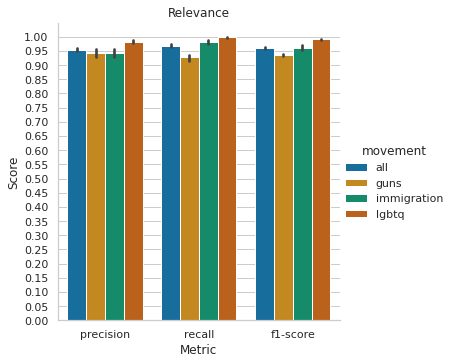

In [163]:
config = {}
config['split'] = 'dev'
config['per_class'] = True
config['classifier'] = 'relevance'
df_sub = subset_results(df,config)
df_sub_long = convert_to_long(df_sub)
sns.catplot(y='value',x='variable',hue='movement',data=df_sub_long,kind='bar')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Relevance')
plt.yticks(np.arange(0,1.01, 0.05))
plt.show()

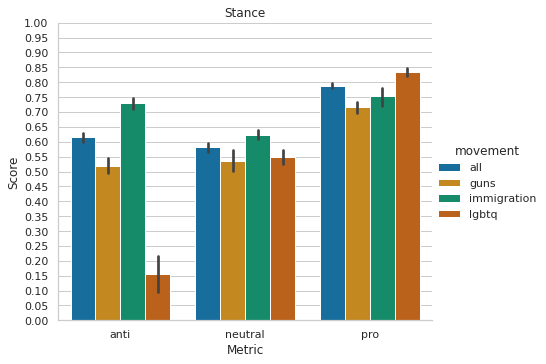

In [168]:
config = {}
config['split'] = 'dev'
config['per_class'] = True
config['classifier'] = 'stance'
df_sub = subset_results(df,config)
# df_sub_long = convert_to_long(df_sub)
sns.catplot(y='f1-score',x='label',hue='movement',data=df_sub,kind='bar',aspect=1.25)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Stance')
plt.yticks(np.arange(0,1.01, 0.05))
plt.show()

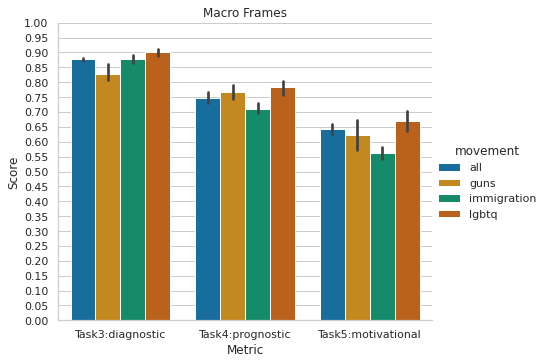

In [169]:
config = {}
config['split'] = 'dev'
config['per_class'] = True
config['classifier'] = 'macro-frames'
df_sub = subset_results(df,config)
# df_sub_long = convert_to_long(df_sub)
sns.catplot(y='f1-score',x='label',hue='movement',data=df_sub,kind='bar',aspect=1.25)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Macro Frames')
plt.yticks(np.arange(0,1.01, 0.05))
plt.show()

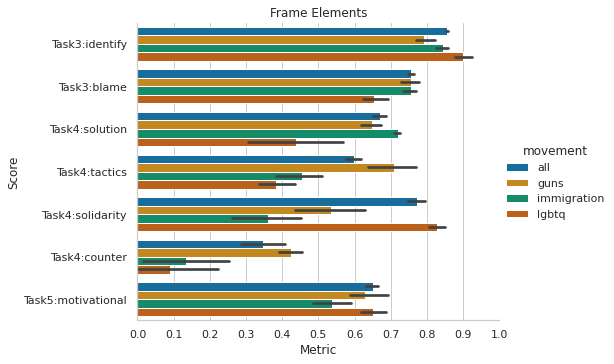

In [209]:
config = {}
config['split'] = 'dev'
config['per_class'] = True
config['classifier'] = 'frame-elements'
df_sub = subset_results(df,config)
# df_sub_long = convert_to_long(df_sub)
sns.catplot(x='f1-score',y='label',hue='movement',data=df_sub,kind='bar',aspect=1.5)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Frame Elements')
plt.xticks(np.arange(0,1.01, 0.1))
plt.show()


In [183]:
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
3,relevance,macro avg,False,all,dev,fold_0,0.926746,0.883886,0.903183,960.0,roberta-base
3,relevance,macro avg,False,guns,dev,fold_0,0.912080,0.908068,0.909978,319.0,roberta-base
3,relevance,macro avg,False,immigration,dev,fold_0,0.926374,0.822219,0.861602,318.0,roberta-base
3,relevance,macro avg,False,lgbtq,dev,fold_0,0.740596,0.621825,0.660358,323.0,roberta-base
3,relevance,macro avg,False,all,dev,fold_1,0.892949,0.881665,0.887148,960.0,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
8,frame-elements,macro avg,False,lgbtq,dev,fold_3,0.562311,0.532198,0.543074,392.0,roberta-base
8,frame-elements,macro avg,False,all,dev,fold_4,0.671889,0.653110,0.659210,1160.0,roberta-base
8,frame-elements,macro avg,False,guns,dev,fold_4,0.637590,0.641746,0.629617,304.0,roberta-base
8,frame-elements,macro avg,False,immigration,dev,fold_4,0.666624,0.509627,0.542763,466.0,roberta-base


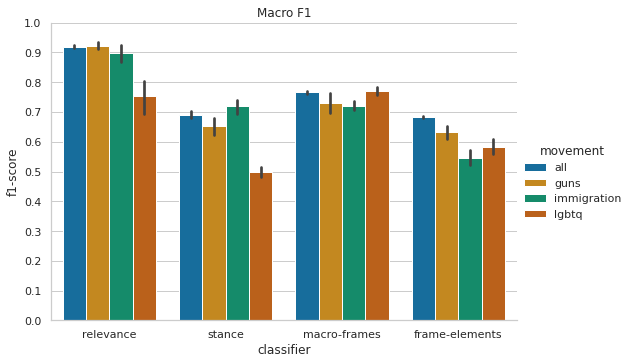

In [10]:
config = {}
config['split'] = 'dev'
config['per_class'] = False
config['label'] = 'macro avg'
config['model'] = 'roberta-ft-st'
df_sub = subset_results(df,config)
# df_sub_long = convert_to_long(df_sub)
sns.catplot(y='f1-score',x='classifier',hue='movement',data=df_sub,kind='bar',aspect=1.5)
plt.title('Macro F1')
plt.yticks(np.arange(0,1.01, 0.1))
plt.show()

In [15]:
config = {}
config['split'] = 'dev'
config['per_class'] = True
config['model'] = 'roberta-ft-st'
df_sub = subset_results(df,config)
df_means = df_sub.groupby(by=['classifier','label','movement']).agg('mean').reset_index()
df_means = df_means.drop(columns=['per_class'])
# df_means.sort_values(by='support')

Text(0.5, 1.0, 'Finetuned Roberta Stance F1 scores')

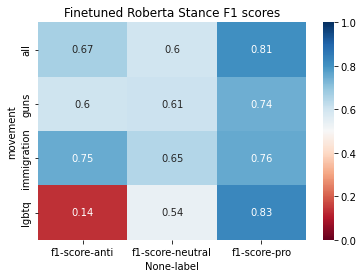

In [40]:
config = {
    'model':'roberta-ft-st',
    'classifier':'stance',
    'split':'dev',
    'label':['pro','neutral','anti']
}
df_stance = subset_results(df,config)
df_stance = df_stance.groupby(['movement','label']).agg('mean').reset_index().round(3)
df_stance_sub = df_stance[['movement','label','f1-score']]
df_stance_sub = df_stance_sub.set_index('movement').pivot(columns='label')
df_stance_sub
sns.heatmap(df_stance_sub,annot=True,cmap='RdBu',vmin=0,vmax=1)
plt.title('Finetuned Roberta Stance F1 scores')

Text(0.5, 1.0, 'Base Roberta Stance F1 scores')

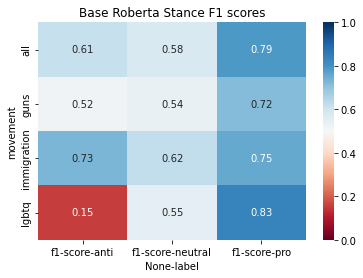

In [41]:
config = {
    'model':'roberta-base',
    'classifier':'stance',
    'split':'dev',
    'label':['pro','neutral','anti']
}
df_stance = subset_results(df,config)
df_stance = df_stance.groupby(['movement','label']).agg('mean').reset_index().round(3)
df_stance_sub = df_stance[['movement','label','f1-score']]
df_stance_sub = df_stance_sub.set_index('movement').pivot(columns='label')
df_stance_sub
sns.heatmap(df_stance_sub,annot=True,cmap='RdBu',vmin=0,vmax=1)
plt.title('Base Roberta Stance F1 scores')

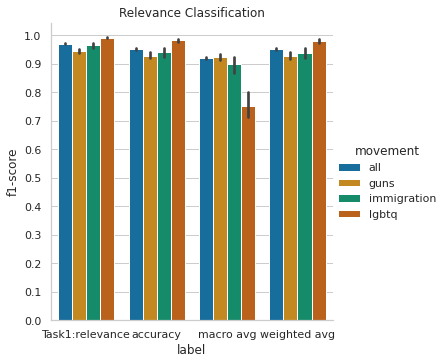

In [145]:
config = {
    'model':'roberta-ft-st',
    'classifier':'relevance',
    'split':'dev',
}
df_rel = subset_results(df,config)
sns.catplot(x="label", y="f1-score", hue="movement", data=df_rel,kind='bar')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Relevance Classification')
plt.show()

In [170]:
config = {
    'model':'roberta-ft-st',
    'classifier':'relevance',
    'split':'dev',
    'label':'Task1:relevance'
}
df_rel = subset_results(df,config)
df_rel.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support
0,all,0.96,0.98,0.97,773.2
1,guns,0.94,0.95,0.94,205.6
2,immigration,0.95,0.98,0.96,255.8
3,lgbtq,0.98,1.00,0.99,311.8


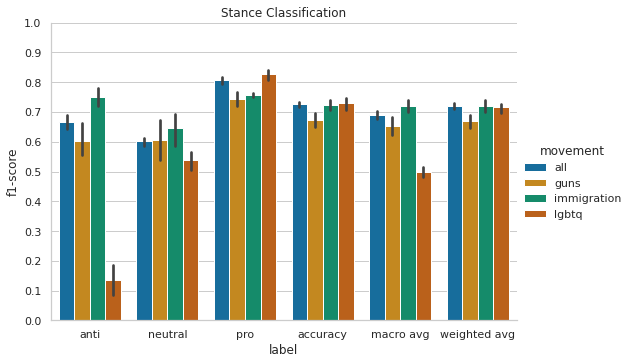

In [155]:
config = {
    'model':'roberta-ft-st',
    'classifier':'stance',
    'split':'dev',
    #'label':['pro','neutral','anti']
}
df_stance = subset_results(df,config)
sns.catplot(x="label", y="f1-score", hue="movement", data=df_stance,kind='bar',aspect=1.5)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Stance Classification')
plt.show()

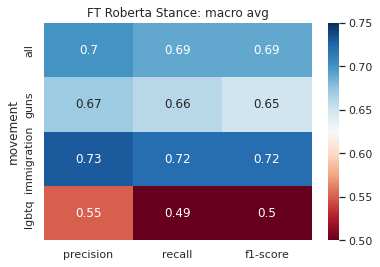

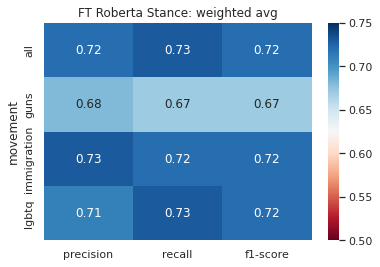

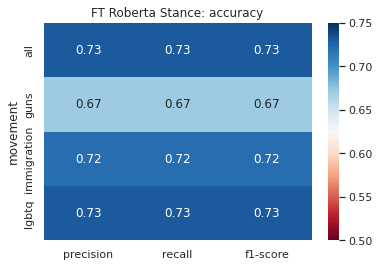

In [29]:
for avg in ['macro avg','weighted avg','accuracy']:
    config = {
        'model':'roberta-ft-st',
        'classifier':'stance',
        'split':'dev',
        'label':avg
    }
    df_stance = subset_results(df,config)
    df_stance = df_stance.drop(columns=['per_class','support']).groupby('movement').agg('mean').reset_index().round(decimals=2)
    sns.heatmap(df_stance.set_index('movement'),annot=True,cmap='RdBu',vmin=.5,vmax=.75)
    plt.title(f'FT Roberta Stance: {avg}')
    plt.show()


In [167]:
config = {
    'model':'roberta-ft-st',
    'classifier':'stance',
    'split':'dev',
    'label':'weighted avg'
}
df_stance = subset_results(df,config)
df_stance.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support
0,all,0.72,0.73,0.72,773.2
1,guns,0.68,0.67,0.67,205.6
2,immigration,0.73,0.72,0.72,255.8
3,lgbtq,0.71,0.73,0.72,311.8


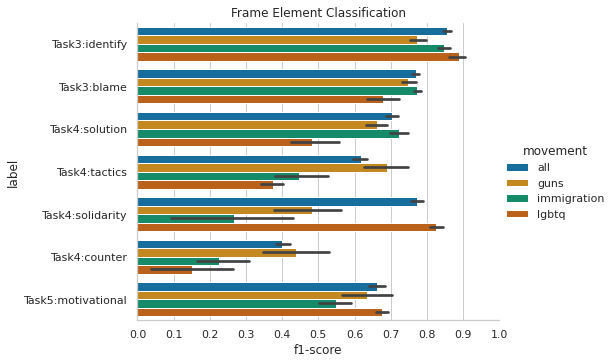

In [30]:
config = {
    'model':'roberta-ft-st',
    'classifier':'frame-elements',
    'split':'dev',
    'per_class':True
    #'label':['pro','neutral','anti']
}
df_elem = subset_results(df,config)
sns.catplot(y="label", x="f1-score", hue="movement", data=df_elem,kind='bar',aspect=1.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.title('Frame Element Classification')
plt.show()

In [163]:
config = {
    'model':'roberta-ft-st',
    'classifier':'frame-elements',
    'split':'dev',
    'label':'macro avg'
}
df_elem = subset_results(df,config)
df_elem.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)


,movement,precision,recall,f1-score,support
0,all,0.68,0.69,0.68,1192.4
1,guns,0.69,0.61,0.63,346.2
2,immigration,0.62,0.53,0.55,450.8
3,lgbtq,0.63,0.56,0.58,395.4


In [164]:
config = {
    'model':'roberta-ft-st',
    'classifier':'frame-elements',
    'split':'dev',
    'label':'micro avg'
}
df_elem = subset_results(df,config)
df_elem.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support
0,all,0.74,0.78,0.76,1192.4
1,guns,0.72,0.68,0.70,346.2
2,immigration,0.73,0.76,0.74,450.8
3,lgbtq,0.77,0.73,0.75,395.4


In [33]:
config = {
    'model':'roberta-ft-st',
    'classifier':'frame-elements',
    'split':'dev',
    'label':'accuracy'
}
df_elem = subset_results(df,config)
df_elem.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support


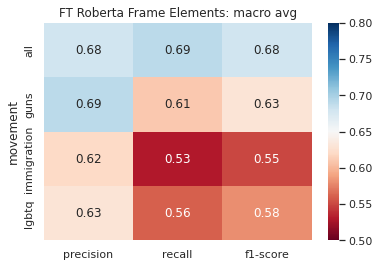

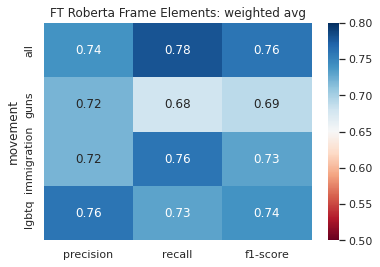

In [36]:
for avg in ['macro avg','weighted avg']:
    config = {
        'model':'roberta-ft-st',
        'classifier':'frame-elements',
        'split':'dev',
        'label':avg
    }
    df_elem = subset_results(df,config)
    df_elem = df_elem.drop(columns=['per_class','support']).groupby('movement').agg('mean').reset_index().round(decimals=2)
    sns.heatmap(df_elem.set_index('movement'),annot=True,cmap='RdBu',vmin=.5,vmax=.8)
    plt.title(f'FT Roberta Frame Elements: {avg}')
    plt.show()


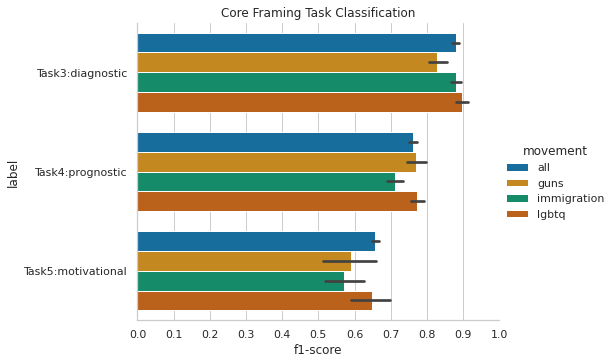

In [37]:
config = {
    'model':'roberta-ft-st',
    'classifier':'macro-frames',
    'split':'dev',
    'per_class':True
    #'label':['pro','neutral','anti']
}
df_elem = subset_results(df,config)
sns.catplot(y="label", x="f1-score", hue="movement", data=df_elem,kind='bar',aspect=1.5)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.title('Core Framing Task Classification')
plt.show()

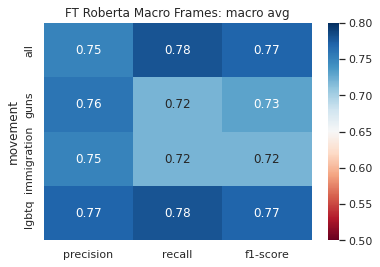

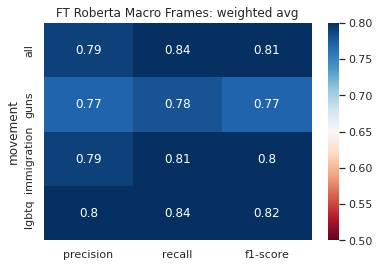

In [40]:
for avg in ['macro avg','weighted avg']:
    config = {
        'model':'roberta-ft-st',
        'classifier':'macro-frames',
        'split':'dev',
        'label':avg
    }
    df_elem = subset_results(df,config)
    df_elem = df_elem.drop(columns=['per_class','support']).groupby('movement').agg('mean').reset_index().round(decimals=2)
    sns.heatmap(df_elem.set_index('movement'),annot=True,cmap='RdBu',vmin=.5,vmax=.8)
    plt.title(f'FT Roberta Macro Frames: {avg}')
    plt.show()

In [173]:
config = {
    'model':'roberta-ft-st',
    'classifier':'macro-frames',
    'split':'dev',
    'label':'macro avg'
}
df_core = subset_results(df,config)
df_core.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support
0,all,0.75,0.78,0.77,896.0
1,guns,0.76,0.72,0.73,258.0
2,immigration,0.75,0.72,0.72,320.0
3,lgbtq,0.77,0.78,0.77,318.0


In [172]:
config = {
    'model':'roberta-ft-st',
    'classifier':'macro-frames',
    'split':'dev',
    'label':'weighted avg'
}
df_core = subset_results(df,config)
df_core.drop(columns=['per_class']).groupby('movement').agg('mean').reset_index().round(decimals=2)

,movement,precision,recall,f1-score,support
0,all,0.79,0.84,0.81,896.0
1,guns,0.77,0.78,0.77,258.0
2,immigration,0.79,0.81,0.80,320.0
3,lgbtq,0.80,0.84,0.82,318.0


In [108]:
macro_frame_df.groupby(['metric','movement']).agg('mean').round(decimals=2)#.sort_values(by='f1-score',ascending=False)

/tmp/ipykernel_2285653/3979148449.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  macro_frame_df.groupby(['metric','movement']).agg('mean').round(decimals=2)#.sort_values(by='f1-score',ascending=False)


precision  recall  f1-score  support
metric             movement                                         
Task3:diagnostic   all               0.84    0.91      0.87    363.0
                   guns              0.80    0.84      0.82     98.2
                   immigration       0.85    0.94      0.89    146.8
                   lgbtq             0.86    0.93      0.89    118.0
Task4:prognostic   all               0.73    0.79      0.76    273.6
                   guns              0.70    0.80      0.75     84.8
                   immigration       0.67    0.74      0.70     85.6
                   lgbtq             0.75    0.77      0.76    103.2
Task5:motivational all               0.67    0.69      0.68     94.8
                   guns              0.76    0.70      0.73     34.0
                   immigration       0.64    0.51      0.56     27.6
                   lgbtq             0.73    0.63      0.68     33.2
macro avg          all               0.75    0.80      0.77    731.4
                   guns              0.76    0.78      0.76    217.0
                   immigration       0.72    0.73      0.72    260.0
                   lgbtq             0.78    0.78      0.78    254.4
weighted avg       all               0.78    0.84      0.81    731.4
                   guns              0.76    0.80      0.78    217.0
                   immigration       0.77    0.83      0.79    260.0
                   lgbtq             0.80    0.83      0.81    254.4

In [204]:
config = {}
config['split'] = 'dev'
config['movement'] = 'immigration'
config['per_class'] = True
df_sub = subset_results(df,config)
df_sub.groupby(by=['classifier','label']).agg('mean').reset_index().sort_values(by='f1-score')

,classifier,label,per_class,precision,recall,f1-score,support
2,frame-elements,Task4:counter,1.0,0.312381,0.087605,0.133126,17.0
3,frame-elements,Task4:solidarity,1.0,0.538333,0.277040,0.361052,12.2
5,frame-elements,Task4:tactics,1.0,0.659745,0.352619,0.455510,22.4
6,frame-elements,Task5:motivational,1.0,0.627543,0.476857,0.536694,30.6
9,macro-frames,Task5:motivational,1.0,0.652284,0.505154,0.563324,30.6
12,stance,neutral,1.0,0.694750,0.566443,0.623959,78.8
8,macro-frames,Task4:prognostic,1.0,0.663150,0.767968,0.710034,105.6
4,frame-elements,Task4:solution,1.0,0.682499,0.762602,0.718969,68.2
11,stance,anti,1.0,0.722012,0.738549,0.729321,78.6
13,stance,pro,1.0,0.712649,0.803012,0.754428,98.4


In [42]:
def plot_stance_confusion(stance_preds_dir,movement=None):
    dfs = []
    for fold in range(5):
        if movement == None:
            filename = os.path.join(stance_preds_dir,'fold_'+str(fold),'dev_relevant.tsv')
        else:
            filename = os.path.join(stance_preds_dir,'fold_'+str(fold),f'dev_relevant_{movement}.tsv')
        df = pd.read_csv(filename,sep='\t')
        dfs.append(df)
    df = pd.concat(dfs)
    df_mat = df[['labels','preds','text']].groupby(by=['labels','preds']).agg('count').reset_index()
    df_mat = df_mat.set_index('labels').pivot(columns='preds')
    ax = sns.heatmap(df_mat,annot=True,cmap='YlOrBr',fmt='.0f',vmax=df_mat.iloc[-1,-1]/2,
                xticklabels=['anti','neutral','pro'],
                yticklabels=['anti','neutral','pro'])
    ax.set(xlabel='preds',ylabel='true')
    if movement==None:
        plt.title('Trained on all movements, sum over 5-folds')
    else:
        plt.title(f'Trained on {movement},sum over 5-folds')
    plt.show()

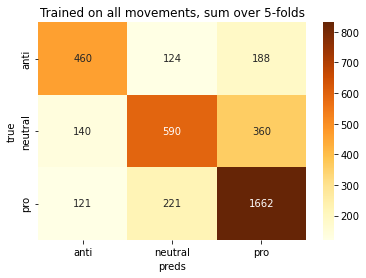

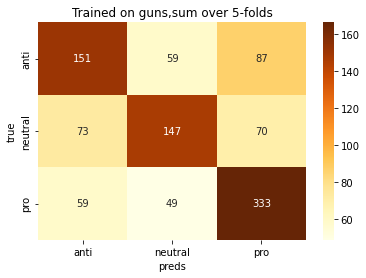

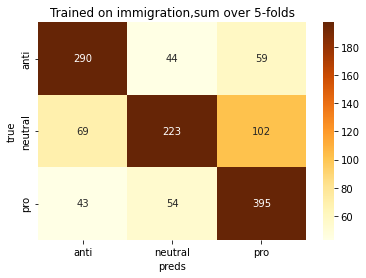

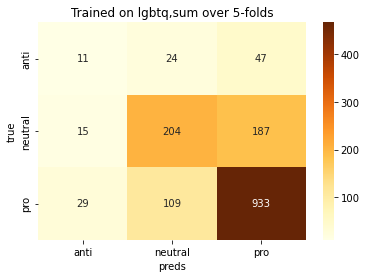

In [43]:
stance_preds_dir = '/home/juliame/social-movements/predictions/roberta-base/stance_06-21-2023'
for movement in [None,'guns','immigration','lgbtq']:
    plot_stance_confusion(stance_preds_dir,movement=movement)

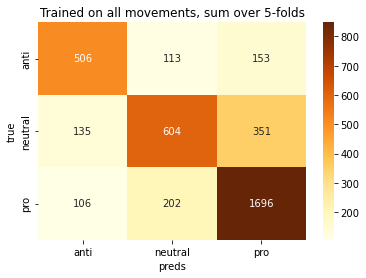

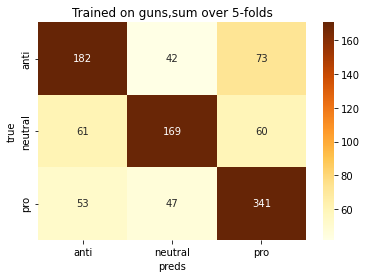

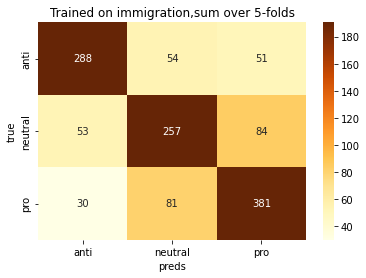

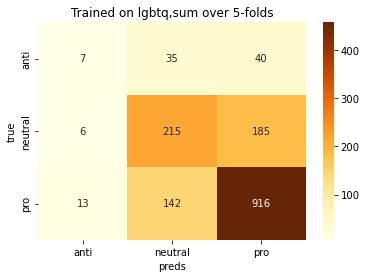

In [44]:
stance_preds_dir = '/home/juliame/social-movements/predictions/roberta-ft-st/stance_06-21-2023'
for movement in [None,'guns','immigration','lgbtq']:
    plot_stance_confusion(stance_preds_dir,movement=movement)

In [220]:
dfs = []
for fold in range(5):
    filename = os.path.join(stance_preds_dir,'fold_'+str(fold),'dev_relevant.tsv')
    df = pd.read_csv(filename,sep='\t')
    dfs.append(df)
df = pd.concat(dfs)

In [225]:
df_mat = df[['labels','preds','text']].groupby(by=['labels','preds']).agg('count').reset_index()
df_mat = df_mat.set_index('labels').pivot(columns='preds')

In [314]:
movement='lgbtq'
filename = os.path.join(stance_preds_dir,'fold_2',f'dev_relevant_{movement}.tsv')
df = pd.read_csv(filename,sep='\t')
true_pro_pred_anti = df[(df['preds']==0) & (df['labels']==2)]['text'].tolist()
true_anti_pred_pro = df[(df['preds']==2) & (df['labels']==0)]['text'].tolist()


In [315]:
for i in df[(df['preds']==0) & (df['labels']==0)]['text'].tolist():
    print(i)

Fuck you to Twitter for saying terfs should ch*ke https://t.co/h69ElBPqkf
@Connornye7 They also allowed transgender women to run. So if you were a Male you can’t run, but if you pretended to be a woman, you could.
Norwegian Cruise Line stocks are losing as badly as Dems after the DEPLORABLES pulled their business! I will not allow transgender in the military!
@IngrahamAngle @BreitbartNews American will not Elect two more Fags. We already had Moochy and Barry. NO MORE. This guy doesn't stand a chance. SO sick of the LGBTQ population.


In [45]:
df

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,test,test,0.958250,0.970796,0.964482,993.000000,roberta-base
2,relevance,accuracy,False,all,test,test,0.940833,0.940833,0.940833,0.940833,roberta-base
3,relevance,macro avg,False,all,test,test,0.904383,0.883949,0.893712,1200.000000,roberta-base
4,relevance,weighted avg,False,all,test,test,0.939666,0.940833,0.940067,1200.000000,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_0,0.948167,0.979112,0.963391,766.000000,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,roberta-ft-st
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,roberta-ft-st
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,roberta-ft-st
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,roberta-ft-st


In [48]:
config = {
    'split':'dev',
    'movement':'all',
    'per_class': True,
    
    
    
}
df_sub = subset_results(df,config)

In [49]:
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,dev,fold_0,0.948167,0.979112,0.963391,766.0,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_1,0.952564,0.961190,0.956858,773.0,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_2,0.964646,0.968314,0.966477,789.0,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_3,0.960307,0.964010,0.962155,778.0,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_4,0.946015,0.968421,0.957087,760.0,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
2,frame-elements,Task4:solution,True,all,dev,fold_4,0.699248,0.738095,0.718147,126.0,roberta-ft-st
3,frame-elements,Task4:tactics,True,all,dev,fold_4,0.651685,0.610526,0.630435,95.0,roberta-ft-st
4,frame-elements,Task4:solidarity,True,all,dev,fold_4,0.820000,0.752294,0.784689,109.0,roberta-ft-st
5,frame-elements,Task4:counter,True,all,dev,fold_4,0.400000,0.400000,0.400000,50.0,roberta-ft-st


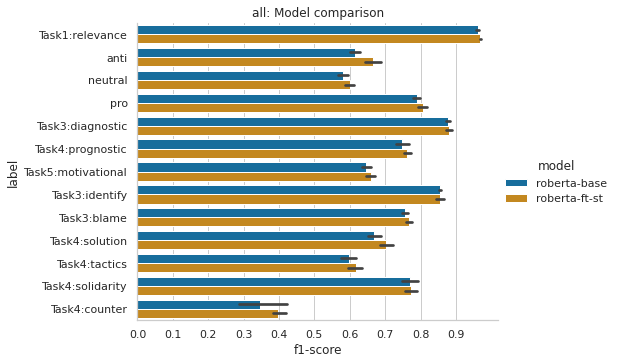

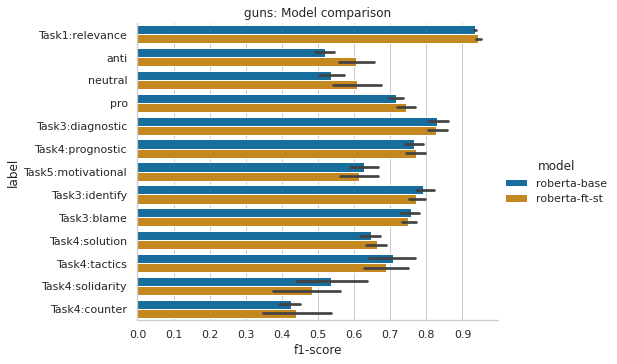

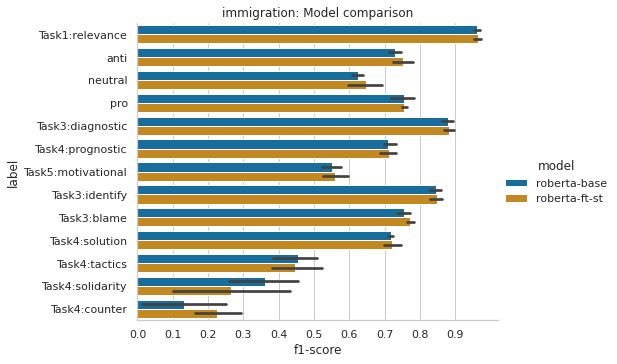

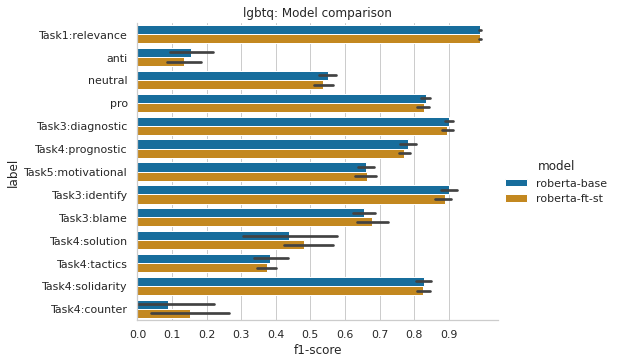

In [68]:
for movement in ['all','guns','immigration','lgbtq']:
    config = {
        'split':'dev',
        'movement':movement,
        'per_class': True,
    }
    df_sub=subset_results(df,config)
    sns.catplot(y='label',x='f1-score',data=df_sub,hue='model',kind='bar',aspect=1.5)
    plt.xticks(np.arange(0,1, 0.1))
    plt.title(movement + ': Model comparison')
    plt.show()
    

Text(631.9039203125001, 0.5, 'motivational frame f1-score')

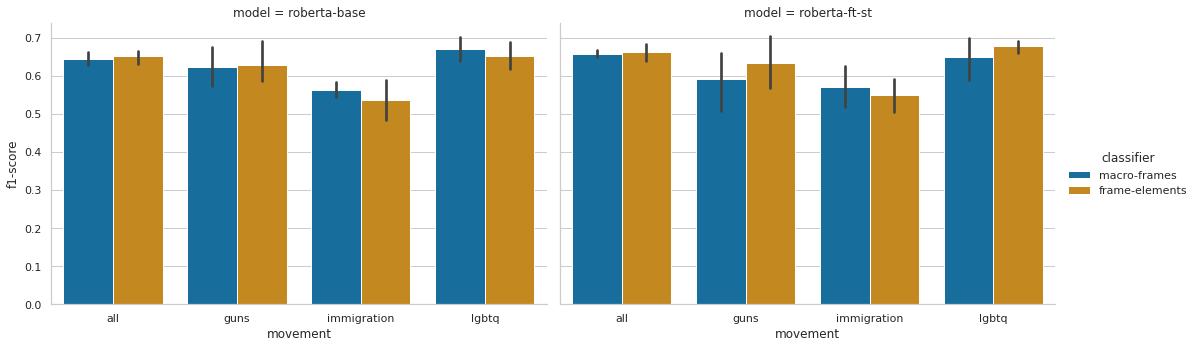

In [75]:
config = {
    'split':'dev',
    'per_class': True,
    'label':'Task5:motivational',
   # 'model':'roberta-ft-st'
}
df_sub=subset_results(df,config)
sns.catplot(x='movement',y='f1-score',data=df_sub,hue='classifier',kind='bar',aspect=1.5,col='model')
# plt.xticks(np.arange(0,1, 0.1))
# plt.show()
#plt.title('Motivational frame performance between macro-frame and frame-element classifier') 
plt.ylabel('motivational frame f1-score')

In [112]:
label='macro avg'
classifier='frame-elements'
for label in ['accuracy','macro avg','micro avg']:
    for classifier in ['relevance','stance','macro-frames','frame-elements']:
        config = {
            'split':'dev',
            'per_class': False,
            'label': label,
            'classifier':classifier,
        }
        df_sub=subset_results(df,config)
        df_sub_avg = df_sub[['movement','model','f1-score']].groupby(by=['movement','model']).agg(
            'mean').reset_index().set_index('model').pivot(columns='movement').round(2
            ).rename(columns={'f1-score':label + ': '+classifier})
        print(df_sub_avg)


              accuracy: relevance                        
movement                      all  guns immigration lgbtq
model                                                    
roberta-base                 0.94  0.92        0.94  0.98
roberta-ft-st                0.95  0.93        0.94  0.98
              accuracy: stance                        
movement                   all  guns immigration lgbtq
model                                                 
roberta-base              0.70  0.61        0.71  0.74
roberta-ft-st             0.73  0.67        0.72  0.73
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
              macro avg: relevance                        
movement                       all  guns immigration lgbtq
model                                                     
roberta-base                  0.90  0.91        0.89  0.73
roberta-ft-st                 0.92  0.92        0.90  0.75
              macro avg: stance                        
movement

In [97]:
config = {
    'split':'dev',
    'per_class': False,
    'label': 'macro avg',
    'classifier':'frame-elements'
}
df_sub=subset_results(df,config)
df_sub[['movement','model','f1-score']].groupby(by=['movement','model']).agg(
    'mean').reset_index().set_index('model').pivot(columns='movement').round(3)

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
8,frame-elements,macro avg,False,all,dev,fold_0,0.688972,0.665972,0.673162,1174.0,roberta-base
8,frame-elements,macro avg,False,guns,dev,fold_0,0.685734,0.655589,0.659240,328.0,roberta-base
8,frame-elements,macro avg,False,immigration,dev,fold_0,0.620736,0.498887,0.519416,439.0,roberta-base
8,frame-elements,macro avg,False,lgbtq,dev,fold_0,0.567671,0.525011,0.536562,407.0,roberta-base
8,frame-elements,macro avg,False,all,dev,fold_1,0.660670,0.659642,0.654974,1213.0,roberta-base
8,frame-elements,macro avg,False,guns,dev,fold_1,0.641684,0.595458,0.604844,361.0,roberta-base
8,frame-elements,macro avg,False,immigration,dev,fold_1,0.598545,0.533485,0.552838,457.0,roberta-base
8,frame-elements,macro avg,False,lgbtq,dev,fold_1,0.621822,0.569340,0.590487,395.0,roberta-base
8,frame-elements,macro avg,False,all,dev,fold_2,0.648821,0.667516,0.656147,1203.0,roberta-base
8,frame-elements,macro avg,False,guns,dev,fold_2,0.686789,0.623844,0.647744,368.0,roberta-base


In [138]:
config = {
    'split':'dev',
    'per_class': True,
    'classifier':'frame-elements',
    #'movement':'all'
    
}
df_sub = subset_results(df,config)

<AxesSubplot:xlabel='support', ylabel='f1-score'>

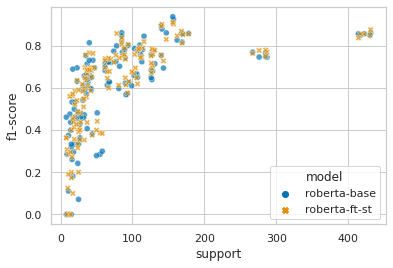

In [140]:
sns.scatterplot(y='f1-score',x='support',hue='model',style='model',data=df_sub,alpha=.7)

<AxesSubplot:xlabel='support', ylabel='precision'>

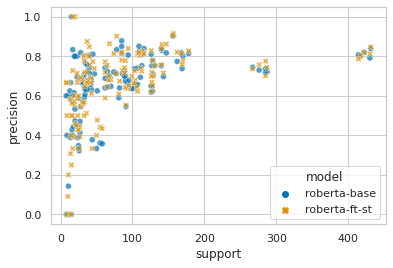

In [141]:
sns.scatterplot(y='precision',x='support',hue='model',style='model',data=df_sub,alpha=.7)

<AxesSubplot:xlabel='support', ylabel='recall'>

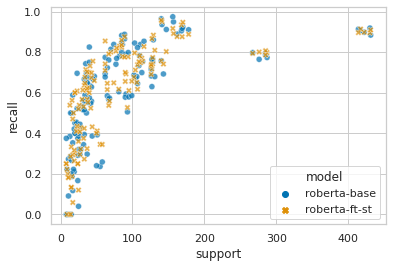

In [142]:
sns.scatterplot(y='recall',x='support',hue='model',style='model',data=df_sub,alpha=.7)

In [41]:
df

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,test,test,0.958250,0.970796,0.964482,993.000000,roberta-base
2,relevance,accuracy,False,all,test,test,0.940833,0.940833,0.940833,0.940833,roberta-base
3,relevance,macro avg,False,all,test,test,0.904383,0.883949,0.893712,1200.000000,roberta-base
4,relevance,weighted avg,False,all,test,test,0.939666,0.940833,0.940067,1200.000000,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_0,0.948167,0.979112,0.963391,766.000000,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,roberta-ft-st
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,roberta-ft-st
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,roberta-ft-st
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,roberta-ft-st


Text(0.5, 1.0, 'Pearson Correlation between F1 and Support')

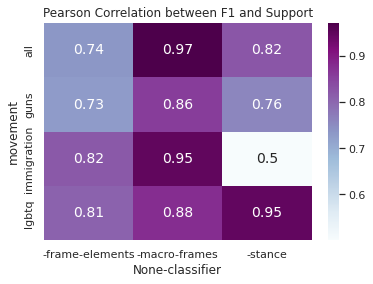

In [73]:
correlations = []
for movement in ['all','guns','lgbtq','immigration']:
    for classifier in ['stance','macro-frames','frame-elements']:
        config = {
            'split':'dev',
            'per_class': True,
            'classifier':classifier,
            'movement':movement,
            'model':'roberta-ft-st'

        }
        df_sub = subset_results(df,config)
        corr = df_sub['f1-score'].corr(df_sub['support'],method='pearson')
        correlations.append([movement,classifier,corr])
df_corr = pd.DataFrame(correlations,columns=['movement','classifier',''])
df_corr = df_corr.set_index('movement').pivot(columns='classifier')
sns.heatmap(df_corr,annot=True,cmap='BuPu', annot_kws={"fontsize":14})
plt.title('Pearson Correlation between F1 and Support')

In [43]:
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
0,frame-elements,Task3:identify,True,all,dev,fold_0,0.820346,0.898104,0.857466,422.0,roberta-base
1,frame-elements,Task3:blame,True,all,dev,fold_0,0.730104,0.764493,0.746903,276.0,roberta-base
2,frame-elements,Task4:solution,True,all,dev,fold_0,0.650407,0.629921,0.640000,127.0,roberta-base
3,frame-elements,Task4:tactics,True,all,dev,fold_0,0.590361,0.604938,0.597561,81.0,roberta-base
4,frame-elements,Task4:solidarity,True,all,dev,fold_0,0.752381,0.699115,0.724771,113.0,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
2,frame-elements,Task4:solution,True,lgbtq,dev,fold_4,0.450000,0.409091,0.428571,22.0,roberta-ft-st
3,frame-elements,Task4:tactics,True,lgbtq,dev,fold_4,0.392857,0.407407,0.400000,27.0,roberta-ft-st
4,frame-elements,Task4:solidarity,True,lgbtq,dev,fold_4,0.901408,0.820513,0.859060,78.0,roberta-ft-st
5,frame-elements,Task4:counter,True,lgbtq,dev,fold_4,0.200000,0.181818,0.190476,11.0,roberta-ft-st


In [91]:
config = {
            'split':'dev',
            'per_class': False,
#             'classifier':classifier,
#             'movement':movement,
            'label':'weighted avg'
        }
df_sub = subset_results(df,config)
df_sub = df_sub.groupby(by=['classifier','label','model']).agg('mean').reset_index()[[
    'classifier','model','f1-score']]

In [92]:
df_sub.set_index(['classifier']).pivot(columns='model').round(3)

f1-score              
model          roberta-base roberta-ft-st
classifier                               
frame-elements        0.727         0.730
macro-frames          0.799         0.799
relevance             0.941         0.949
stance                0.684         0.707

In [18]:
def combine_evals_each_movement(eval_dir,date): 
    dfs = []
    for classifier in ['relevance','stance','macro-frames','frame-elements']:
        classifier_eval_dir = os.path.join(eval_dir,f'{classifier}_{date}')
        for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
            for movement in ['guns','immigration','lgbtq']:
                df = load_eval_file(os.path.join(classifier_eval_dir,fold),classifier,fold=fold,movement=movement)
                dfs.append(df)
        for movement in ['guns','immigration','lgbtq']:
            df = load_eval_file(classifier_eval_dir,classifier,split='test',movement=movement)
            dfs.append(df)
    df = pd.concat(dfs)
    return df

In [19]:
eval_base_dir = "/home/juliame/social-movements/evaluations/"
model_name = 'roberta-ft-st'
date='06-21-2023'
eval_dir = os.path.join(eval_base_dir,model_name,'all_movements_model_eval')
df_comb = combine_evals_each_movement(eval_dir,date)
df_comb['model'] = 'combined_movements'

eval_dir = os.path.join(eval_base_dir,model_name)
df_per = combine_evals_each_movement(eval_dir,date)
df_per['model'] = 'per_movement'

df_comb = pd.concat([df_comb,df_per])

In [21]:
df_comb

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,guns,dev,fold_0,0.926829,0.964467,0.945274,197.000000,combined_movements
2,relevance,accuracy,False,guns,dev,fold_0,0.931034,0.931034,0.931034,0.931034,combined_movements
3,relevance,macro avg,False,guns,dev,fold_0,0.932713,0.920758,0.926027,319.000000,combined_movements
4,relevance,weighted avg,False,guns,dev,fold_0,0.931330,0.931034,0.930552,319.000000,combined_movements
1,relevance,Task1:relevance,True,immigration,dev,fold_0,0.923077,0.992126,0.956357,254.000000,combined_movements
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,per_movement
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,per_movement
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,per_movement
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,per_movement


In [14]:
config = {
   # 'model':'roberta-ft-st',
    #'classifier':'relevance',
    'split':'dev',
    'per_class':True
}
df_sub = subset_results(df,config)

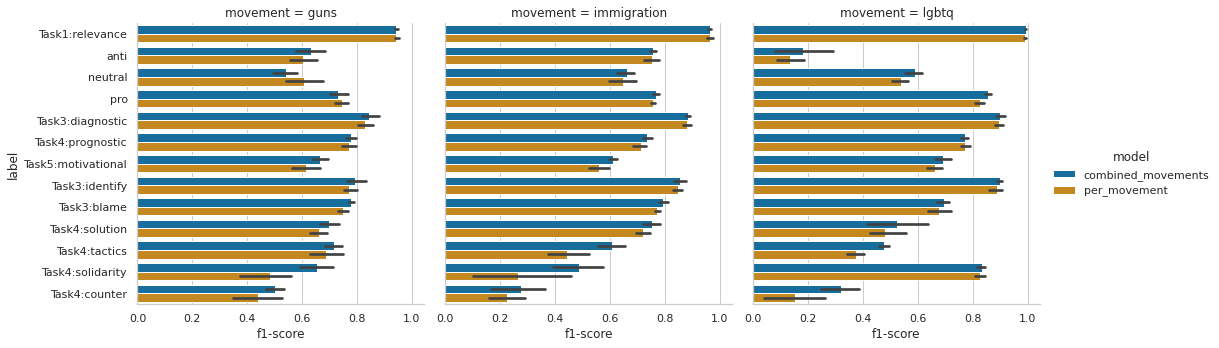

In [15]:
sns.catplot(x='f1-score',y='label',hue='model',data=df_sub,col='movement',kind='bar')

In [60]:
config = {
    'split':'dev',
    'per_class':False,
    'label': 'macro avg'
}
df_sub = subset_results(df,config)

df_sub = df_sub[['model','classifier','movement','f1-score']]
df_sub = df_sub.groupby(by=['model','classifier','movement']).agg('mean').reset_index()
df_sub.set_index(['classifier','movement']).pivot(columns='model').round(3)

f1-score             
model                      combined_movements per_movement
classifier     movement                                   
frame-elements guns                     0.687        0.632
               immigration              0.626        0.547
               lgbtq                    0.635        0.582
macro-frames   guns                     0.760        0.730
               immigration              0.745        0.721
               lgbtq                    0.785        0.772
relevance      guns                     0.921        0.922
               immigration              0.897        0.897
               lgbtq                    0.813        0.753
stance         guns                     0.634        0.652
               immigration              0.728        0.718
               lgbtq                    0.542        0.500

In [62]:
config = {
    'split':'dev',
    'per_class':True,
    #'label': 'macro avg'
}
df_sub = subset_results(df,config)

df_sub = df_sub[['model','label','movement','f1-score']]
df_sub = df_sub.groupby(by=['model','label','movement']).agg('mean').reset_index()
df_sub.set_index(['label','movement']).pivot(columns='model').round(3)

f1-score             
model                          combined_movements per_movement
label              movement                                   
Task1:relevance    guns                     0.943        0.944
                   immigration              0.963        0.963
                   lgbtq                    0.993        0.991
Task3:blame        guns                     0.778        0.749
                   immigration              0.795        0.773
                   lgbtq                    0.694        0.679
Task3:diagnostic   guns                     0.844        0.828
                   immigration              0.884        0.881
                   lgbtq                    0.900        0.895
Task3:identify     guns                     0.794        0.771
                   immigration              0.857        0.848
                   lgbtq                    0.899        0.888
Task4:counter      guns                     0.502        0.439
                   immigration              0.275        0.226
                   lgbtq                    0.319        0.151
Task4:prognostic   guns                     0.778        0.771
                   immigration              0.734        0.711
                   lgbtq                    0.773        0.771
Task4:solidarity   guns                     0.653        0.483
                   immigration              0.488        0.266
                   lgbtq                    0.832        0.826
Task4:solution     guns                     0.697        0.663
                   immigration              0.752        0.722
                   lgbtq                    0.525        0.481
Task4:tactics      guns                     0.715        0.688
                   immigration              0.607        0.445
                   lgbtq                    0.475        0.374
Task5:motivational guns                     0.665        0.613
                   immigration              0.611        0.560
                   lgbtq                    0.691        0.663
anti               guns                     0.631        0.604
                   immigration              0.757        0.752
                   lgbtq                    0.183        0.135
neutral            guns                     0.539        0.607
                   immigration              0.661        0.648
                   lgbtq                    0.588        0.537
pro                guns                     0.731        0.745
                   immigration              0.766        0.756
                   lgbtq                    0.855        0.828

In [24]:
binary_eval_dir = '/home/juliame/social-movements/evaluations/roberta_binary_models/roberta-ft-st/'


In [28]:
res = []
for shortname in os.listdir(binary_eval_dir):
    for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
        filename = os.path.join(binary_eval_dir,shortname,fold,'dev_relevant.tsv')
        df = pd.read_csv(filename,sep='\t')
        df_pos_class = df[df['Unnamed: 0']=='1']
        res.append([fold,shortname,df_pos_class['f1-score'][1]])

In [30]:
df = pd.DataFrame(res,columns=['fold','category','f1-score'])

In [34]:
df.groupby('category').agg('mean').reset_index().sort_values(by='f1-score',ascending=False)

,category,f1-score
2,identify,0.859439
0,blame,0.764860
4,solidarity,0.749032
5,solution,0.692781
3,motivational,0.660210
6,tactics,0.606573
1,counter,0.357216


In [6]:
df

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,test,test,0.958250,0.970796,0.964482,993.000000,roberta-base
2,relevance,accuracy,False,all,test,test,0.940833,0.940833,0.940833,0.940833,roberta-base
3,relevance,macro avg,False,all,test,test,0.904383,0.883949,0.893712,1200.000000,roberta-base
4,relevance,weighted avg,False,all,test,test,0.939666,0.940833,0.940067,1200.000000,roberta-base
1,relevance,Task1:relevance,True,all,dev,fold_0,0.948167,0.979112,0.963391,766.000000,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,roberta-ft-st
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,roberta-ft-st
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,roberta-ft-st
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,roberta-ft-st


In [7]:
df[df['split']=='test']

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,all,test,test,0.958250,0.970796,0.964482,993.000000,roberta-base
2,relevance,accuracy,False,all,test,test,0.940833,0.940833,0.940833,0.940833,roberta-base
3,relevance,macro avg,False,all,test,test,0.904383,0.883949,0.893712,1200.000000,roberta-base
4,relevance,weighted avg,False,all,test,test,0.939666,0.940833,0.940067,1200.000000,roberta-base
1,relevance,Task1:relevance,True,guns,test,test,0.937984,0.941634,0.939806,257.000000,roberta-base
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,roberta-ft-st
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,roberta-ft-st
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,roberta-ft-st
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,roberta-ft-st


In [50]:
config = {
    'split':'dev',
    'per_class':True,
    #'label': 'macro avg',
    'classifier':['macro-frames','frame-elements']
}
df_sub = subset_results(df_comb,config)

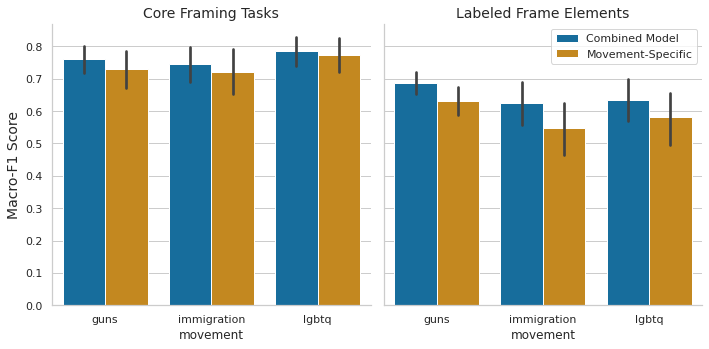

In [51]:
g = sns.catplot(x='movement',y='f1-score',data=df_sub,hue='model',col='classifier',kind='bar',legend=False)
plt.title('Macro-F1 score')
ax0,ax1 = g.axes.flatten()
ax0.set_title('Core Framing Tasks',fontsize=14)
ax1.set_title('Labeled Frame Elements',fontsize=14)
ax0.set_ylabel('Macro-F1 Score',fontsize=14)
L = plt.legend()
L.get_texts()[0].set_text('Combined Model')
L.get_texts()[1].set_text('Movement-Specific')
#plt.savefig('/home/juliame/social-movements/results/combined_vs_single_movement.pdf',bbox_inches='tight')

In [54]:
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,guns,dev,fold_0,0.926829,0.964467,0.945274,197.0,combined_movements
1,relevance,Task1:relevance,True,immigration,dev,fold_0,0.923077,0.992126,0.956357,254.0,combined_movements
1,relevance,Task1:relevance,True,lgbtq,dev,fold_0,0.984277,0.993651,0.988942,315.0,combined_movements
1,relevance,Task1:relevance,True,guns,dev,fold_1,0.937500,0.933014,0.935252,209.0,combined_movements
1,relevance,Task1:relevance,True,immigration,dev,fold_1,0.966038,0.962406,0.964218,266.0,combined_movements
...,...,...,...,...,...,...,...,...,...,...,...
2,frame-elements,Task4:solution,True,lgbtq,test,test,0.320000,0.380952,0.347826,21.0,per_movement
3,frame-elements,Task4:tactics,True,lgbtq,test,test,0.481481,0.333333,0.393939,39.0,per_movement
4,frame-elements,Task4:solidarity,True,lgbtq,test,test,0.769841,0.843478,0.804979,115.0,per_movement
5,frame-elements,Task4:counter,True,lgbtq,test,test,0.142857,0.125000,0.133333,16.0,per_movement


In [40]:
df_res.columns.get_level_values(0)
df_res.columns

MultiIndex([(   'split',     ''),
            ('movement',     ''),
            (   'model',     ''),
            ('f1-score', 'mean'),
            ('f1-score',  'std')],
           )

In [77]:
config = {
    'split':'dev',
    'per_class':True,
    'movement':'all',
    'model':'roberta-ft-st',
    #'label': 'macro avg',
    #'classifier':['macro-frames','frame-elements']
}
df_sub = subset_results(df,config)

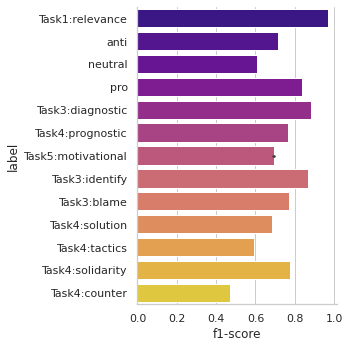

In [85]:
c = sns.color_palette('colorblind')
pal = [c[1]] + [c[2]]*3 + [c[4]]*3 + [c[0]]*6

In [92]:
categories = ['Relevance','Conservative Stance','Neutral/Unclear Stance','Progressive Stance',
              'Diagnostic','Prognostic','Motivational','Identification','Blame','Solution',
             'Tactics','Solidarity','Counterframing']

/tmp/ipykernel_4107074/3947778803.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)


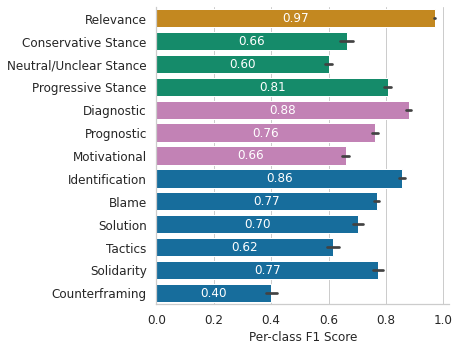

In [98]:
g = sns.catplot(y='label',x='f1-score',data=df_sub,kind='bar',palette=pal,aspect=1.25)
ax = g.axes[0,0]
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='center',color='white',fontsize=12)
ax.set_yticklabels(categories,fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)
ax.set_ylabel('')
ax.set_xlabel('Per-class F1 Score',fontsize=12)
plt.savefig('/home/juliame/social-movements/results/overall_per_class_dev_results.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'Finetuned Roberta Stance F1 scores')

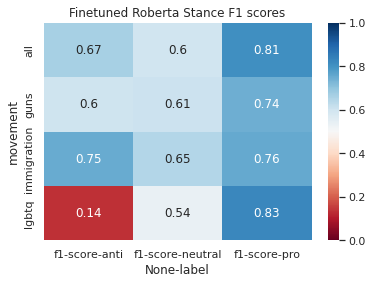

In [99]:
config = {
    'model':'roberta-ft-st',
    'classifier':'stance',
    'split':'dev',
    'label':['pro','neutral','anti']
}
df_stance = subset_results(df,config)
df_stance = df_stance.groupby(['movement','label']).agg('mean').reset_index().round(3)
df_stance_sub = df_stance[['movement','label','f1-score']]
df_stance_sub = df_stance_sub.set_index('movement').pivot(columns='label')
df_stance_sub
sns.heatmap(df_stance_sub,annot=True,cmap='RdBu',vmin=0,vmax=1)
plt.title('Finetuned Roberta Stance F1 scores')

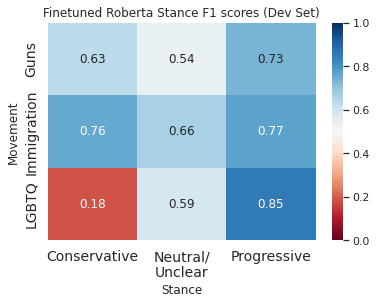

In [122]:
config = {
    'model':'combined_movements',
    'classifier':'stance',
    'split':'dev',
    'label':['pro','neutral','anti']
}
df_stance = subset_results(df_comb,config)
df_stance = df_stance.groupby(['movement','label']).agg('mean').reset_index().round(3)
df_stance_sub = df_stance[['movement','label','f1-score']]
df_stance_sub = df_stance_sub.set_index('movement').pivot(columns='label')

sns.heatmap(df_stance_sub,annot=True,cmap='RdBu',vmin=0,vmax=1)
plt.title('Finetuned Roberta Stance F1 scores (Dev Set)')
plt.xlabel('Stance')
plt.ylabel('Movement')
plt.xticks(ticks=[x+.5 for x in range(0,3)],labels=['Conservative','Neutral/\nUnclear','Progressive'],fontsize=14)
plt.yticks(ticks=[x+.5 for x in range(0,3)],labels=['Guns','Immigration','LGBTQ'],fontsize=14)
plt.savefig("/home/juliame/social-movements/results/movement_stance_dev.pdf")

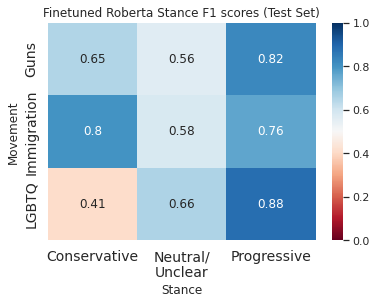

In [124]:
config = {
    'model':'combined_movements',
    'classifier':'stance',
    'split':'test',
    'label':['pro','neutral','anti']
}
df_stance = subset_results(df_comb,config)
df_stance = df_stance.groupby(['movement','label']).agg('mean').reset_index().round(3)
df_stance_sub = df_stance[['movement','label','f1-score']]
df_stance_sub = df_stance_sub.set_index('movement').pivot(columns='label')

sns.heatmap(df_stance_sub,annot=True,cmap='RdBu',vmin=0,vmax=1)
plt.title('Finetuned Roberta Stance F1 scores (Test Set)')
plt.xlabel('Stance')
plt.ylabel('Movement')
plt.xticks(ticks=[x+.5 for x in range(0,3)],labels=['Conservative','Neutral/\nUnclear','Progressive'],fontsize=14)
plt.yticks(ticks=[x+.5 for x in range(0,3)],labels=['Guns','Immigration','LGBTQ'],fontsize=14)
plt.savefig("/home/juliame/social-movements/results/movement_stance_test.pdf")

In [125]:
config = {
    'split':'dev',
    'per_class': True,
    'classifier':classifier,
    'movement':movement,
    'model':'combined_movements'

}
df_sub = subset_results(df,config)
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
1,relevance,Task1:relevance,True,guns,dev,fold_0,0.926829,0.964467,0.945274,197.000000,combined_movements
2,relevance,accuracy,False,guns,dev,fold_0,0.931034,0.931034,0.931034,0.931034,combined_movements
3,relevance,macro avg,False,guns,dev,fold_0,0.932713,0.920758,0.926027,319.000000,combined_movements
4,relevance,weighted avg,False,guns,dev,fold_0,0.931330,0.931034,0.930552,319.000000,combined_movements
1,relevance,Task1:relevance,True,immigration,dev,fold_0,0.923077,0.992126,0.956357,254.000000,combined_movements
...,...,...,...,...,...,...,...,...,...,...,...
6,frame-elements,Task5:motivational,True,lgbtq,test,test,0.639344,0.812500,0.715596,48.000000,per_movement
7,frame-elements,micro avg,False,lgbtq,test,test,0.704819,0.722222,0.713415,486.000000,per_movement
8,frame-elements,macro avg,False,lgbtq,test,test,0.546260,0.564083,0.551051,486.000000,per_movement
9,frame-elements,weighted avg,False,lgbtq,test,test,0.700089,0.722222,0.708505,486.000000,per_movement


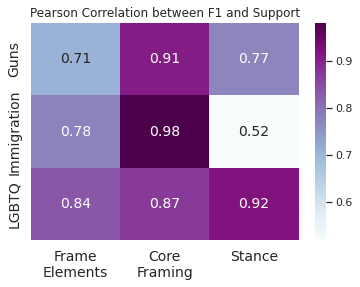

In [153]:
correlations = []
for movement in ['guns','lgbtq','immigration']:
    for classifier in ['stance','macro-frames','frame-elements']:
        config = {
            'movement':movement,
            'classifier':classifier,
            'split':'dev',
            'model':'combined_movements',
            'per_class': True
        }
        df_sub = subset_results(df_comb,config)
        corr = df_sub['f1-score'].corr(df_sub['support'],method='pearson')
        correlations.append([movement,classifier,corr])
df_corr = pd.DataFrame(correlations,columns=['movement','classifier',''])
df_corr = df_corr.set_index('movement').pivot(columns='classifier')
sns.heatmap(df_corr,annot=True,cmap='BuPu', annot_kws={"fontsize":14})
plt.title('Pearson Correlation between F1 and Support')
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=[x+.5 for x in range(0,3)],labels=['Frame\nElements','Core\nFraming','Stance'],fontsize=14)
plt.yticks(ticks=[x+.5 for x in range(0,3)],labels=['Guns','Immigration','LGBTQ'],fontsize=14)
plt.savefig("/home/juliame/social-movements/results/f1_support_corr.pdf",bbox_inches='tight')

In [142]:
correlations

[['guns', 'stance', 0.7724666972879974],
 ['guns', 'macro-frame', nan],
 ['guns', 'frame-elements', 0.7067457426619315],
 ['lgbtq', 'stance', 0.9184951292291075],
 ['lgbtq', 'macro-frame', nan],
 ['lgbtq', 'frame-elements', 0.8353571576987816],
 ['immigration', 'stance', 0.518042484087454],
 ['immigration', 'macro-frame', nan],
 ['immigration', 'frame-elements', 0.7756856484157052]]

In [149]:
config = {
    'split':'dev',
    'per_class': True,
    'classifier':['stance','macro-frames','frame-elements'],
    'model':'combined_movements'

}
df_sub = subset_results(df_comb,config)
df_sub

,classifier,label,per_class,movement,split,fold,precision,recall,f1-score,support,model
0,stance,anti,True,guns,dev,fold_0,0.568627,0.491525,0.527273,59.0,combined_movements
1,stance,neutral,True,guns,dev,fold_0,0.666667,0.454545,0.540541,66.0,combined_movements
2,stance,pro,True,guns,dev,fold_0,0.603960,0.847222,0.705202,72.0,combined_movements
0,stance,anti,True,immigration,dev,fold_0,0.738636,0.783133,0.760234,83.0,combined_movements
1,stance,neutral,True,immigration,dev,fold_0,0.689655,0.519481,0.592593,77.0,combined_movements
...,...,...,...,...,...,...,...,...,...,...,...
2,frame-elements,Task4:solution,True,lgbtq,dev,fold_4,0.565217,0.590909,0.577778,22.0,combined_movements
3,frame-elements,Task4:tactics,True,lgbtq,dev,fold_4,0.461538,0.444444,0.452830,27.0,combined_movements
4,frame-elements,Task4:solidarity,True,lgbtq,dev,fold_4,0.825000,0.846154,0.835443,78.0,combined_movements
5,frame-elements,Task4:counter,True,lgbtq,dev,fold_4,0.285714,0.363636,0.320000,11.0,combined_movements


In [152]:
config = {
    'split':'dev',
    'per_class': True,
    'movement':'all',
    'classifier':['stance','macro-frames','frame-elements'],
    'model':'roberta-ft-st'

}

df_sub = subset_results(df,config)

In [154]:
df_sub['f1-score'].corr(df_sub['support'],method='pearson')

0.7756856484157052

In [ ]:
# Tables that we need for the paper: 
# Per-Class: Label, dev f1 mean (std), dev f1 support (std), test f1 mean, test f1 support
# Aggregated: Category, dev micro f1, dev macro f1, test micro f1, test macro f1
# Movement vs all: 

In [63]:
config = {
    'per_class':True,
    #'classifier':['macro-frames','frame-elements']
}
df_sub = subset_results(df_comb,config)

df_res = df_sub[['split','model','movement','f1-score']].groupby(['split','movement','model']).agg(['mean','std']).reset_index()
df_res#.flatten().pivot(columns=['split','model'])
df_res.columns = df_res.columns.get_level_values(0)
df_res.columns = ['split','movement','model','f1-score','std']

df_res = df_res.pivot(index=['split','model'],columns=['movement'],values=['f1-score','std']).reset_index()
df_res.columns = df_res.columns.get_level_values(0)
df_res.columns = ['split','model','f1 guns','f1 immigration','f1 lgbtq','std guns','std immigration','std lgbtq']
df_res.round(3)
#index='foo', columns='bar', values='baz'

,split,model,f1 guns,f1 immigration,f1 lgbtq,std guns,std immigration,std lgbtq
0,dev,combined_movements,0.710,0.697,0.673,0.121,0.177,0.234
1,dev,per_movement,0.680,0.651,0.634,0.145,0.223,0.267
2,test,combined_movements,0.734,0.709,0.694,0.121,0.153,0.204
3,test,per_movement,0.706,0.679,0.643,0.117,0.218,0.248


In [91]:
config = {
    'per_class': True,
    'split':'test',
    'model':'combined_movements',
    'classifier': 'stance'
}

df_sub = subset_results(df_comb,config)
df_res = df_sub[['label','movement','f1-score']].groupby(by=['label','movement']).agg('mean').reset_index()
df_res.pivot(index='movement',columns='label',values='f1-score').reset_index().round(3)

label,movement,anti,neutral,pro
0,guns,0.652,0.559,0.824
1,immigration,0.798,0.582,0.763
2,lgbtq,0.410,0.656,0.879


In [112]:
config = {
    'per_class': True,
    'split':'dev',
    'model':'combined_movements',
    'classifier': 'stance'
}

df_sub = subset_results(df_comb,config)
df_res = df_sub[['label','movement','f1-score']].groupby(by=['label','movement']).agg(['mean','std']).reset_index()
#df_res.pivot(index='movement',columns='label',values='f1-score').reset_index().round(3)
df_res.columns = df_res.columns.get_level_values(0)
df_res.columns = ['label','movement','f1 mean','std']
df_res = df_res.pivot(index=['movement'],columns=['label'],values=['f1 mean','std']).round(3).reset_index()
df_res.columns = ['movement','f1 anti','f1 neutral','f1 pro','std anti','std neutral','std pro']


In [113]:
df_res

,movement,f1 anti,f1 neutral,f1 pro,std anti,std neutral,std pro
0,guns,0.631,0.539,0.731,0.074,0.060,0.045
1,immigration,0.757,0.661,0.766,0.013,0.041,0.015
2,lgbtq,0.183,0.588,0.855,0.129,0.040,0.015


In [168]:
config = {
    'per_class': False,
    'model':'roberta-ft-st',
    'movement': 'all',
    'classifier':['macro-frames','frame-elements']
}

df_sub = subset_results(df,config)
df_sub = df_sub[['classifier','label','split','f1-score']].groupby(
    by=['classifier','label','split']).agg('mean').reset_index()
df_sub = df_sub.pivot(index=['classifier','label'],columns='split',values='f1-score').round(3).reset_index()
df_sub.columns = ['classifier','label','dev f1','test f1']
df_sub

,classifier,label,dev f1,test f1
0,frame-elements,macro avg,0.683,0.695
1,frame-elements,micro avg,0.758,0.763
2,frame-elements,samples avg,0.611,0.621
3,frame-elements,weighted avg,0.756,0.759
4,macro-frames,macro avg,0.766,0.780
5,macro-frames,micro avg,0.811,0.815
6,macro-frames,samples avg,0.669,0.676
7,macro-frames,weighted avg,0.810,0.814


In [155]:
config = {
    'per_class': True,
    'split':'dev',
    'model':'roberta-ft-st',
    'movement': 'all',
    'classifier':['macro-frames','frame-elements']
}

df_sub = subset_results(df,config)
df_sub = df_sub[['classifier','label','precision','recall','f1-score','support']].groupby(
    by=['classifier','label']).agg('mean').reset_index()
df_sub.sort_values(by='label')

,classifier,label,precision,recall,f1-score,support
0,frame-elements,Task3:blame,0.742555,0.797125,0.768555,280.0
7,macro-frames,Task3:diagnostic,0.845817,0.916524,0.879716,457.8
1,frame-elements,Task3:identify,0.813455,0.902554,0.855583,422.8
2,frame-elements,Task4:counter,0.417450,0.386773,0.398143,51.6
8,macro-frames,Task4:prognostic,0.736048,0.788263,0.761215,334.6
3,frame-elements,Task4:solidarity,0.800847,0.749777,0.773267,114.4
4,frame-elements,Task4:solution,0.671504,0.739897,0.703472,130.0
5,frame-elements,Task4:tactics,0.618348,0.620511,0.616678,90.0
6,frame-elements,Task5:motivational,0.661757,0.662468,0.661886,103.6
9,macro-frames,Task5:motivational,0.678241,0.637172,0.656686,103.6


In [147]:
config = {
    'per_class': False,
    'split':'test',
    'model':'roberta-ft-st',
    'movement': 'all',
    'classifier':['macro-frames','frame-elements']
}

df_sub = subset_results(df,config)
df_sub[['classifier','label','precision','recall','f1-score','support']]

,classifier,label,precision,recall,f1-score,support
3,macro-frames,micro avg,0.798878,0.832220,0.815209,1198.0
4,macro-frames,macro avg,0.773678,0.787591,0.779893,1198.0
5,macro-frames,weighted avg,0.796868,0.832220,0.813797,1198.0
6,macro-frames,samples avg,0.696542,0.690164,0.676401,1198.0
7,frame-elements,micro avg,0.751990,0.774763,0.763207,1585.0
8,frame-elements,macro avg,0.706237,0.692943,0.695432,1585.0
9,frame-elements,weighted avg,0.748003,0.774763,0.758896,1585.0
10,frame-elements,samples avg,0.642850,0.636438,0.621088,1585.0


In [141]:
config = {
    'per_class': True,
    'split':'test',
    'model':'roberta-ft-st',
    'movement': 'all',
}

df_sub = subset_results(df,config)
df_sub[['f1-score','support']].corr(method='pearson')
# .848 (Pearson correlation between f1 score and support)

,f1-score,support
f1-score,1.000000,0.847771
support,0.847771,1.000000


In [142]:
config = {
    'per_class': True,
    'split':'dev',
    'model':'roberta-ft-st',
    'movement': 'all',
}

df_sub = subset_results(df,config)
df_sub[['f1-score','support']].corr(method='pearson')
# .822 (Pearson correlation between f1 score and support)

,f1-score,support
f1-score,1.000000,0.822256
support,0.822256,1.000000
